# Visualisation of LFP & Sleep scoring

### Load LFP and packages

In [1]:
cd "//10.69.168.1/crnldata/waking/audrey_hay/L1imaging/AnalysedMarch2023/"

\\10.69.168.1\crnldata\waking\audrey_hay\L1imaging\AnalysedMarch2023


In [2]:
from scipy import signal
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.widgets import Slider, Button, Cursor
from scipy import fftpack
import pandas as pd
from pathlib import Path
import os
from IPython.display import display
from ipyfilechooser import FileChooser
from ephyviewer import mkQApp, MainViewer, TraceViewer
from ephyviewer import AnalogSignalSourceWithScatter
import ephyviewer
from scipy.stats import zscore
from scipy.interpolate import interp1d
from itertools import groupby


from scipy.signal import find_peaks
from scipy.signal import chirp, find_peaks, peak_widths

%matplotlib widget

In [3]:
dpath = "//10.69.168.1/crnldata/waking/audrey_hay/L1imaging/AnalysedMarch2023/Gaelle/Baseline_recording"
try:
    %store -r dpath
except:
    print("data not in strore")
    dpath ="//10.69.168.1/crnldata/waking/audrey_hay/L1imaging/AnalysedMarch2023/Gaelle/Baseline_recording"

# Set up Initial Basic Parameters#
minian_path = "."

fc1 = FileChooser(dpath,select_default=True, show_only_dirs = True, title = "<b>Open Ephys folder</b>")
display(fc1)

# Sample callback function
def update_my_folder(chooser):
    global dpath
    dpath = chooser.selected
    %store dpath
    return 

# Register callback function
fc1.register_callback(update_my_folder)

FileChooser(path='\\10.69.168.1\crnldata\waking\audrey_hay\L1imaging\AnalysedMarch2023\Gaelle\Baseline_recordi…

Stored 'dpath' (str)
Stored 'dpath' (str)
Stored 'dpath' (str)
Stored 'dpath' (str)
Stored 'dpath' (str)
Stored 'dpath' (str)
Stored 'dpath' (str)


In [25]:
folder_base = Path(dpath) 

filename2 = folder_base / f'RawDataChannelExtractedDS.npy'

ScoringFile = folder_base / f'ScoredSleep_AB.npy'
ScoringFile2 = folder_base / f'ScoredSleep_AH.npy'
SleepScoredTS=np.load(ScoringFile)
SleepScoredTS2=np.load(ScoringFile2)

Channels = '//10.69.168.1/crnldata/waking/audrey_hay/L1imaging/AnalysedMarch2023/LFPChannels_perMice.xlsx' 

freqLFP=1000
All = np.load(filename2, mmap_mode= 'r')

def readfile(file):
  with open(file, encoding="utf-8") as file:
    list = []
    for row in file:
      temp = row.split()
      list.append(temp[:])
    return list

mice = os.path.basename(os.path.dirname(os.path.dirname(folder_base)))
#mice = os.path.basename(os.path.dirname(os.path.dirname(os.path.dirname(folder_base))))

allchannels = pd.read_excel(Channels)

PFCch1=int(allchannels[mice][0].split(',')[0])
PFCch2=int(allchannels[mice][0].split(',')[1])
CA1ch1=int(allchannels[mice][2].split(',')[0])
CA1ch2=int(allchannels[mice][2].split(',')[1])
S1ch1=int(allchannels[mice][1].split(',')[0])
S1ch2=int(allchannels[mice][1].split(',')[1])
EMGch1=int(allchannels[mice][3])

PFC  =  All[:, PFCch1]-All[:, PFCch2] 
CA1  =  All[:, CA1ch1]-All[:, CA1ch2] 
S1  =  All[:, S1ch1]-All[:, S1ch2] 
EMG  =  All[:, EMGch1]

# Upscale Scoring
indices = np.linspace(0, len(SleepScoredTS) - 1, len(SleepScoredTS))
new_indices = np.linspace(0, len(SleepScoredTS) - 1, len(EMG))
interpolated_func = interp1d(indices, SleepScoredTS, kind='previous')
SleepScoredTS_upscaled = interpolated_func(new_indices)
SleepScoredTS_upscaled = np.round(SleepScoredTS_upscaled * 2) / 2


# Upscale Scoring
indices = np.linspace(0, len(SleepScoredTS2) - 1, len(SleepScoredTS2))
new_indices = np.linspace(0, len(SleepScoredTS2) - 1, len(EMG))
interpolated_func = interp1d(indices, SleepScoredTS2, kind='previous')
SleepScoredTS_upscaled2 = interpolated_func(new_indices)
SleepScoredTS_upscaled2 = np.round(SleepScoredTS_upscaled2 * 2) / 2



In [26]:
#OldSWSdetection=folder_base / f'SWRproperties_8sd_AB.xlsx'
#SWR_prop = pd.read_excel(OldSWSdetection, index_col=0)            
OldSWSdetection=folder_base / f'SWRproperties.csv'
SWR_prop = pd.read_csv(OldSWSdetection, index_col=0)         
try: 
    SWR_prop['toKeep'] = SWR_prop['toKeep'].astype(str)
    SWR_prop  = SWR_prop[SWR_prop['toKeep'].isin(['VRAI', 'True'])]        
except: None
SWR_peak = np.transpose(SWR_prop['peak time'].astype(int))
SWR_start = np.transpose(SWR_prop['start time'].astype(int))
SWR_end = np.transpose(SWR_prop['end time'].astype(int))
"""
OldS1spdldetection=folder_base / f'Spindlesproperties_S1_7sd_AB.xlsx'
S1spdl_prop = pd.read_excel(OldS1spdldetection, index_col=0)            
S1spdl_prop['toKeep'] = S1spdl_prop['toKeep'].astype(str)
S1spdl_prop  = S1spdl_prop[S1spdl_prop['toKeep'].isin(['VRAI', 'True'])]
S1spdl_peak = np.transpose(S1spdl_prop['peak time'].astype(int))
S1spdl_start = np.transpose(S1spdl_prop['start time'].astype(int))
S1spdl_end = np.transpose(S1spdl_prop['end time'].astype(int))

OldPFCspdldetection=folder_base / f'Spindlesproperties_PFC_7sd_AB.xlsx'
PFCspdl_prop = pd.read_excel(OldPFCspdldetection, index_col=0)            
PFCspdl_prop['toKeep'] = PFCspdl_prop['toKeep'].astype(str)
PFCspdl_prop  = PFCspdl_prop[PFCspdl_prop['toKeep'].isin(['VRAI', 'True'])]       
PFCspdl_peak = np.transpose(PFCspdl_prop['peak time'].astype(int))
PFCspdl_start = np.transpose(PFCspdl_prop['start time'].astype(int))
PFCspdl_end = np.transpose(PFCspdl_prop['end time'].astype(int))
"""

Spdldetection=folder_base / f'Spindleproperties_S1&PFC.csv'
Spdl_prop = pd.read_csv(Spdldetection, index_col=0)  
Spdl_prop['toKeep'] = Spdl_prop['toKeep'].astype(str)
Spdl_prop  = Spdl_prop[Spdl_prop['toKeep'].isin(['VRAI', 'True'])]   

S1Spdl_prop= Spdl_prop[Spdl_prop['CTX']=='S1']
S1spdl_peak = np.transpose(S1Spdl_prop['peak time'].astype(int))
S1spdl_start = np.transpose(S1Spdl_prop['start time'].astype(int))
S1spdl_end = np.transpose(S1Spdl_prop['end time'].astype(int))

PFCSpdl_prop= Spdl_prop[Spdl_prop['CTX']=='PFC']
PFCspdl_peak = np.transpose(PFCSpdl_prop['peak time'].astype(int))
PFCspdl_start = np.transpose(PFCSpdl_prop['start time'].astype(int))
PFCspdl_end = np.transpose(PFCSpdl_prop['end time'].astype(int))

GlobalSpdl_prop= Spdl_prop[Spdl_prop['CTX']=='S1PFC']
GBLspdl_peak = np.transpose(GlobalSpdl_prop['peak time'].astype(int))
GBLspdl_start = np.transpose(GlobalSpdl_prop['start time'].astype(int))
GBLspdl_end = np.transpose(GlobalSpdl_prop['end time'].astype(int))




# EphyViewer
### LFPs, FFT, Sleep scoring


In [27]:
from ephyviewer import mkQApp, MainViewer, TraceViewer, TimeFreqViewer, CsvEpochSource, EpochEncoder,EpochViewer
from ephyviewer import InMemoryAnalogSignalSource

app = mkQApp()

sample_rate = freqLFP
t_start = 0.

combined = np.stack([(S1), (PFC), (CA1)/5, (EMG)/5], axis = 1)

#create 2 familly scatters from theses 2 indexes
scatter_indexes = {0: PFCspdl_start, 1: PFCspdl_end, 2: S1spdl_start, 3: S1spdl_end, 4: SWR_start, 5: SWR_end}
#and asign them to some channels each
scatter_channels = {0: [1], 1: [1], 2: [0], 3: [0], 4: [2], 5: [2]}

#mapp = {0: 'NREM', 0.5: 'N2', 1: 'REM', 1.5: 'Wake'}
source = AnalogSignalSourceWithScatter(combined, sample_rate, t_start, scatter_indexes, scatter_channels, scatter_colors= {0: '#FFFFFF', 1: '#222222', 2: '#FFFFFF', 3: '#222222', 4: '#FFFFFF', 5: '#222222'}, channel_names=['S1','PFC', 'CA1', 'EMG', 'Scoring'])

#Create the main window that can contain several viewers
#win = MainViewer()
win = MainViewer(debug=True, show_auto_scale=True)

#view1 = TraceViewer.from_numpy(combined, sample_rate, t_start, 'Signals')
view1 = TraceViewer(source=source)

#Parameters can be set in script
view1.params['scale_mode'] = 'same_for_all'
view1.params['display_labels'] = True

view1.auto_scale()

#And also parameters for each channel
view1.by_channel_params['ch0', 'color'] = '#88FF88' #FF0000 red, #00FF00 green, and #0000FF blue
view1.by_channel_params['ch1', 'color'] = '#8888FF'
view1.by_channel_params['ch2', 'color'] = '#FF8888'
view1.by_channel_params['ch3', 'color'] = '#FFFFFF'

#create a time freq viewer conencted to the same source
view3 = TimeFreqViewer(source=source, name='FFT')

view3.params['show_axis'] = True
view3.params['timefreq', 'f_start'] = 1
view3.params['timefreq', 'f_stop'] = 30
view3.params['timefreq', 'deltafreq'] = 1 #interval in Hz

view3.by_channel_params['ch0', 'clim'] = 300
view3.by_channel_params['ch1', 'clim'] = 300
view3.by_channel_params['ch2', 'clim'] = 300
view3.by_channel_params['ch0', 'visible'] = True
view3.by_channel_params['ch1', 'visible'] = True
view3.by_channel_params['ch2', 'visible'] = True
view3.by_channel_params['ch3', 'visible'] = False


array=SleepScoredTS_upscaled
substates_duration = [len(list(group)) for key, group in groupby(array)]
substates_duration =np.array(substates_duration)/freqLFP
substates_identity = [key for key, _ in groupby(array)]
substates_end = np.array(substates_duration).cumsum()
substates_start =np.append([0],substates_end[:-1])
mapp = {0: 'NREM', 0.5: 'N2', 1: 'REM', 1.5: 'Wake'}
substates_identity = [mapp[num] for num in substates_identity]
substates_identity = np.array(substates_identity)

all_epochs = []
ep_times=[]
ep_durations=[]
ep_labels=[]

states=['NREM', 'N2', 'REM', 'Wake']
for c,st in enumerate(states):
    ep_times=[]
    ep_durations=[]
    ep_labels=[]
    for subs in range(len(substates_duration)):
        if substates_identity[subs] == st:
            ep_times.append(substates_start[subs])
            ep_durations.append(substates_duration[subs])
            ep_labels.append(subs)
    all_epochs.append({ 'time':np.array(ep_times), 'duration':np.array(ep_durations), 'label':np.array(ep_labels), 'name':st })

source_ep = ephyviewer.InMemoryEpochSource(all_epochs=all_epochs)
view2= EpochViewer(source=source_ep, name='Scoring AB')

view2.by_channel_params['ch0', 'color'] = '#5555FF'
view2.by_channel_params['ch1', 'color'] = '#AA00FF'
view2.by_channel_params['ch2', 'color'] = '#00AA00'
view2.by_channel_params['ch3', 'color'] = '#FFFFFF'

"""
array=SleepScoredTS_upscaled2
substates_duration = [len(list(group)) for key, group in groupby(array)]
substates_duration =np.array(substates_duration)/freqLFP
substates_identity = [key for key, _ in groupby(array)]
substates_end = np.array(substates_duration).cumsum()
substates_start =np.append([0],substates_end[:-1])
mapp = {0: 'NREM', 0.5: 'N2', 1: 'REM', 1.5: 'Wake'}
substates_identity = [mapp[num] for num in substates_identity]
substates_identity = np.array(substates_identity)

all_epochs = []
ep_times=[]
ep_durations=[]
ep_labels=[]

states=['NREM', 'N2', 'REM', 'Wake']
for c,st in enumerate(states):
    ep_times=[]
    ep_durations=[]
    ep_labels=[]
    for subs in range(len(substates_duration)):
        if substates_identity[subs] == st:
            ep_times.append(substates_start[subs])
            ep_durations.append(substates_duration[subs])
            ep_labels.append(subs)
    all_epochs.append({ 'time':np.array(ep_times), 'duration':np.array(ep_durations), 'label':np.array(ep_labels), 'name':st })

source_ep2 = ephyviewer.InMemoryEpochSource(all_epochs=all_epochs)
view4= EpochViewer(source=source_ep2, name='Scoring AH')

view4.by_channel_params['ch0', 'color'] = '#5555FF'
view4.by_channel_params['ch1', 'color'] = '#AA00FF'
view4.by_channel_params['ch2', 'color'] = '#00AA00'
view4.by_channel_params['ch3', 'color'] = '#FFFFFF'
"""

#add them to mainwindow
win.add_view(view1)
win.add_view(view2)
#win.add_view(view4)
win.add_view(view3)

#Run
win.show()
app.exec_()

debug True
QT_MODE PyQt5
refresh duration for  0.0 s
refresh duration for  0.0 s
refresh duration for Scoring AB 0.0 s
refresh duration for  0.0 s
refresh duration for Scoring AB 0.0 s
refresh duration for FFT 0.0029985904693603516 s
refresh duration for  0.0 s
refresh duration for Scoring AB 0.0 s
refresh duration for FFT 0.0009980201721191406 s
refresh duration for  0.0 s
refresh duration for Scoring AB 0.0 s
refresh duration for FFT 0.0 s
refresh duration for  0.0 s
refresh duration for Scoring AB 0.0 s
refresh duration for FFT 0.0 s
refresh duration for  0.0 s
refresh duration for Scoring AB 0.0 s
refresh duration for FFT 0.01562952995300293 s
refresh duration for  0.0 s
refresh duration for Scoring AB 0.0 s
refresh duration for FFT 0.0 s
refresh duration for  0.001004934310913086 s
refresh duration for Scoring AB 0.0 s
refresh duration for FFT 0.0010721683502197266 s
refresh duration for  0.0 s
refresh duration for Scoring AB 0.0 s
refresh duration for FFT 0.0 s
refresh duration f

0

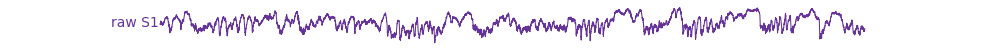

In [55]:
beg=200
fin=210
sample_rate=1000

import matplotlib.colors as mcolors

S1e=S1[beg*sample_rate:fin*sample_rate]
PFCe=PFC[beg*sample_rate:fin*sample_rate]

plt.close()
plt.figure(figsize=(10,.5))
hex_color = '#663399'
plt.plot(zscore(S1e), linewidth=.75, color=hex_color)
plt.text(-20, np.mean(zscore(S1e)), 'raw S1', color=hex_color, 
        ha='right', va='center', fontsize=10)  

plt.axis('off')  # Hides the axis lines and labels
plt.show()


In [56]:
plt.savefig(f'C:/Users/Manip2/Documents/ElifePaper/Rawdata/Extract{mice}_{folder_base.parts[-2]}_S1SpdlBis_raw&filtLFPs_{beg}to{fin}s.svg', format='svg', bbox_inches='tight', pad_inches=0, transparent=True)

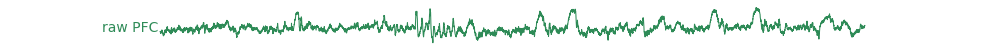

In [57]:
hex_color = '#2E8B57'

plt.close()
plt.figure(figsize=(10,.5))
plt.plot(zscore(PFCe), linewidth=.75, color=hex_color)
plt.text(-20, np.mean(zscore(PFCe)), 'raw PFC', color=hex_color, 
        ha='right', va='center', fontsize=10)  

plt.axis('off')  # Hides the axis lines and labels
plt.show()


In [58]:
plt.savefig(f'C:/Users/Manip2/Documents/ElifePaper/Rawdata/Extract{mice}_{folder_base.parts[-2]}_PFCSpdlBis_raw&filtLFPs_{beg}to{fin}s.svg', format='svg', bbox_inches='tight', pad_inches=0, transparent=True)

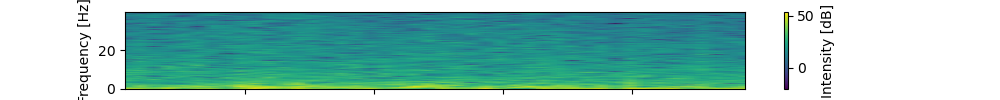

In [38]:
from scipy.signal import spectrogram

frequencies, times, Sxx = spectrogram(S1e, 100)
# Specify the frequency range of interest (e.g., 40 to 130 Hz)
freq_range =  (frequencies <= 40)

# Filter the spectrogram to include only the specified frequency range
filtered_frequencies = frequencies[freq_range]
filtered_Sxx = Sxx[freq_range, :]

# Plot the spectrogram with the adjusted frequency range
plt.figure(figsize=(10, 1))
plt.pcolormesh(times, filtered_frequencies, 10 * np.log10(filtered_Sxx), shading='gouraud')
plt.ylabel('Frequency [Hz]')
plt.xlabel('Time [sec]')
plt.colorbar(label='Intensity [dB]')


plt.show()

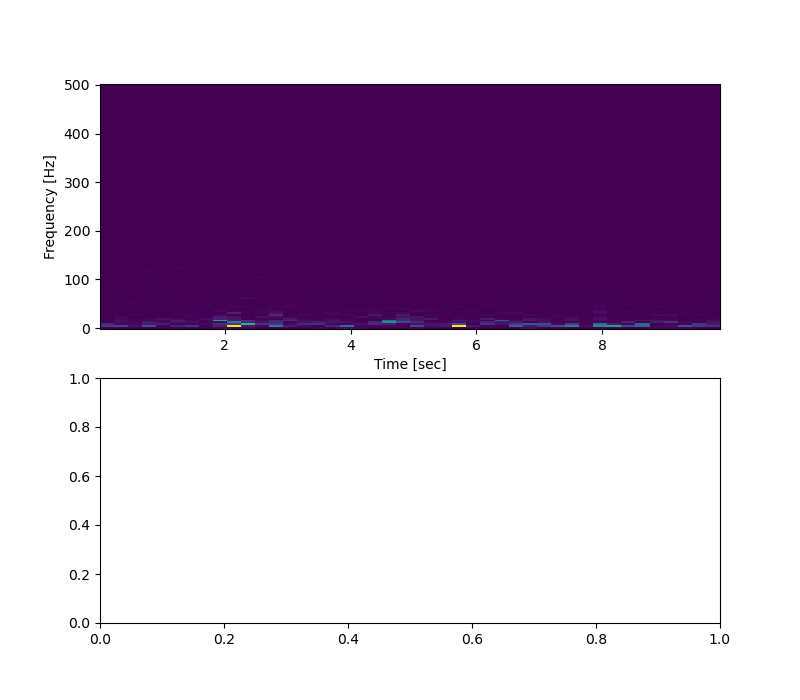

In [54]:
import numpy as np
from scipy import signal
from scipy.fft import fftshift
import matplotlib.pyplot as plt
plot.close()   
fig, ax = plt.subplots(2, figsize=(8, 7))

f, t, Sxx = signal.spectrogram(S1e, sample_rate)
ax[0].pcolormesh(t, f, Sxx)
ax[0].set_ylabel('Frequency [Hz]')
ax[0].set_xlabel('Time [sec]')

plt.show()

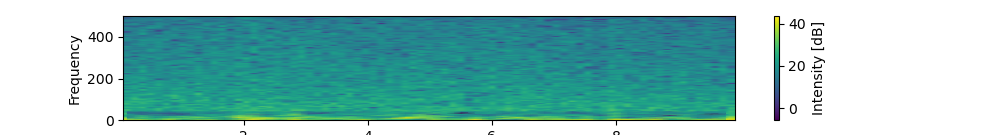

In [69]:
import matplotlib.pyplot as plot
import numpy as np
plot.close()   
# Plot the spectrogram
powerSpectrum, freqenciesFound, time, imageAxis = plot.specgram(S1e, Fs=sample_rate)
plot.xlabel('Time')
plot.ylabel('Frequency')
plot.show()   

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from PyEMD import EMD

# Generate a sample signal
fs = sample_rate  # Sampling frequency
t = np.arange(0, 10, 1/fs)  # Time vector
signal = S1e

# Perform Empirical Mode Decomposition (EMD)
emd = EMD()
imfs = emd(signal)

# Plot the IMFs
plt.figure(figsize=(10, 8))
for i, imf in enumerate(imfs):
    plt.subplot(len(imfs), 1, i+1)
    plt.plot(t, imf)
    plt.title(f'IMF {i+1}')
plt.tight_layout()
plt.show()


ModuleNotFoundError: No module named 'PyEMD'

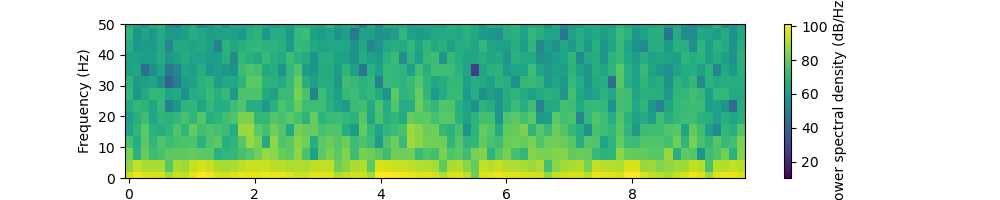

In [59]:
import numpy as np
import matplotlib.pyplot as plt

# Define the parameters for the spectrogram
window_size = 256  # Window size for the FFT
overlap    = 128  # Overlap between windows

# Window the signal
window = np.hanning(window_size)
windows = [S1e[i:i+window_size] * window for i in range(0, len(S1e)-window_size, window_size-overlap)]

# Compute the FFT for each window
spectrogram = [np.abs(np.fft.rfft(win))**2 for win in windows]

# Transpose the result to have time on the x-axis and frequency on the y-axis
spectrogram = np.array(spectrogram).T

# Plot the spectrogram
frequencies = np.fft.rfftfreq(window_size, d=1.0/sample_rate)
time = np.arange(len(spectrogram[0])) * (window_size - overlap) / sample_rate
plt.close()
plt.figure(figsize=(10, 2))

plt.pcolormesh(time, frequencies, 10 * np.log10(spectrogram))
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.colorbar(label="Power spectral density (dB/Hz)")
plt.ylim([0, 50])
plt.show()
